Importing modules

In [49]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt

Loading dataset

In [50]:
#(xTrain,yTrain),(xTest,yTest)=tf.keras.datasets.mnist.load_data()
(xTrain,yTrain),(xTest,yTest)=tf.keras.datasets.fashion_mnist.load_data()

Preprocessing data

In [51]:
def preprocData(dSet):
    dSetRes=dSet.reshape(dSet.shape[0],-1).T/255.0
    dSetMean=np.mean(dSetRes,axis=1).reshape(-1,1)
    return(dSetRes,dSetMean)
rm=np.random.RandomState(5000).permutation(xTrain.shape[0])

xTrainPreproc,trainSetMean=preprocData(xTrain)
xTrainPreproc-=trainSetMean
xTrainPreproc=xTrainPreproc[:,rm]
xTestPreproc,_=preprocData(xTest)
xTestPreproc-=trainSetMean

Define class for minibatch orthogonal transform training

In [61]:
class sparseOrthoTransformTrainerMiniBatch:
    def __init__(self,trainData,spp,numIter,batchSize,dictInit=None):
        if(dictInit is None):
            randSel=np.random.RandomState(2500).permutation(xTrainPreproc.shape[1])[:1001]
            dictInit,_,_=np.linalg.svd(xTrainPreproc[:,randSel])
        self.spp=spp
        self.err=np.zeros((numIter*trainData.shape[1]//batchSize,1))
        self.trainData=trainData
        self.dict=dictInit
        self.numIter=numIter
        self.batchSize=batchSize
    def spCode(self,trainDataMiniBatch):
        proj=self.dict.T@trainDataMiniBatch
        proj_s=np.sort(np.abs(proj),axis=0)[-self.spp,:]
        proj=proj*(np.abs(proj)>=proj_s)
        self.proj=proj
    def dictUpdate(self,trainDataMiniBatch):
        mat=self.proj@trainDataMiniBatch.T
        u,_,v=np.linalg.svd(mat)
        self.dict=v.T@u.T
    def batchTrainingData(self):
        trainDataBatched=[self.trainData[:,rm[i*self.batchSize:(i+1)*self.batchSize]] for i in range(self.trainData.shape[1]//self.batchSize)]
        return trainDataBatched
    def fitDictSingleIter(self,trainDataBatched,epochNum,dispInt=10):
        #err=np.zeros((len(trainDataBatched),1))
        for i in range(len(trainDataBatched)):
            self.spCode(trainDataBatched[i])
            self.err[epochNum*len(trainDataBatched)+i]=np.mean((trainDataBatched[i]-self.dict@self.proj)**2)
            if(i%dispInt==0):
                print(f'Batch:{i} Error:{self.err[epochNum*len(trainDataBatched)+i][0]:0.4f}')
            self.dictUpdate(trainDataBatched[i])
    def fitDictAllIter(self,dispInt=20):
        trainDataBatched=self.batchTrainingData()
        for i in range(self.numIter):
            print(f'_______Epoch:{i+1}_________')
            self.fitDictSingleIter(trainDataBatched,i,dispInt=dispInt)
spp=70
numIter=30
batchSize=1000
TrainDict=sparseOrthoTransformTrainerMiniBatch(xTrainPreproc,spp,numIter,batchSize)
TrainDict.fitDictAllIter(dispInt=20)

_______Epoch:1_________
Batch:0 Error:0.0072
Batch:20 Error:0.0062
Batch:40 Error:0.0058
_______Epoch:2_________
Batch:0 Error:0.0055
Batch:20 Error:0.0053
Batch:40 Error:0.0053
_______Epoch:3_________
Batch:0 Error:0.0052
Batch:20 Error:0.0051
Batch:40 Error:0.0051
_______Epoch:4_________
Batch:0 Error:0.0051
Batch:20 Error:0.0050
Batch:40 Error:0.0050
_______Epoch:5_________
Batch:0 Error:0.0050
Batch:20 Error:0.0050
Batch:40 Error:0.0050
_______Epoch:6_________
Batch:0 Error:0.0050
Batch:20 Error:0.0049
Batch:40 Error:0.0050
_______Epoch:7_________
Batch:0 Error:0.0049
Batch:20 Error:0.0049
Batch:40 Error:0.0049
_______Epoch:8_________
Batch:0 Error:0.0049
Batch:20 Error:0.0049
Batch:40 Error:0.0049
_______Epoch:9_________
Batch:0 Error:0.0049
Batch:20 Error:0.0049
Batch:40 Error:0.0049
_______Epoch:10_________
Batch:0 Error:0.0049
Batch:20 Error:0.0048
Batch:40 Error:0.0049
_______Epoch:11_________
Batch:0 Error:0.0048
Batch:20 Error:0.0048
Batch:40 Error:0.0049
_______Epoch:12____

Display learned dictionary

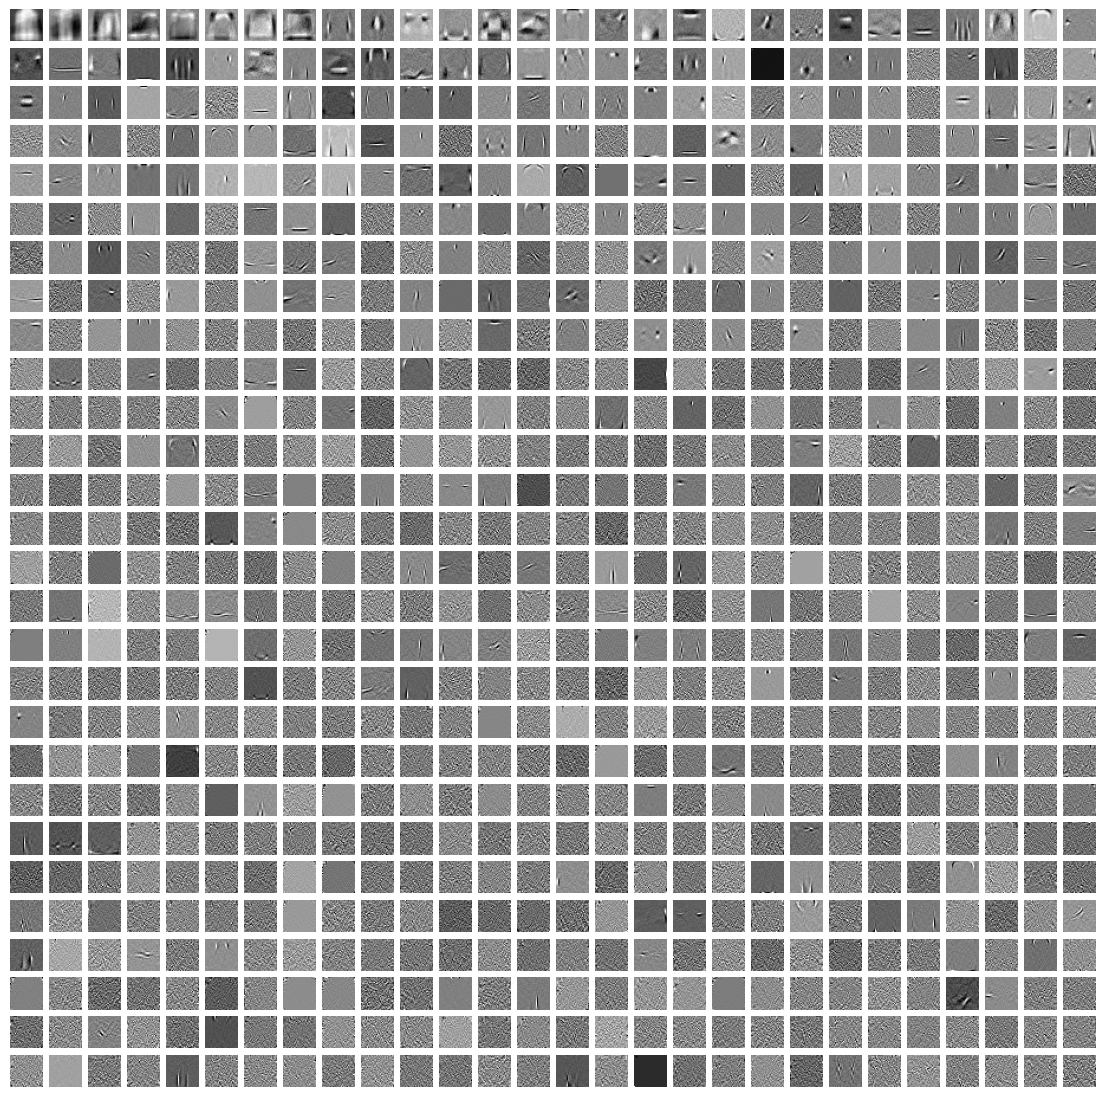

In [62]:
fig,ax=plt.subplots(nrows=xTrain.shape[1],ncols=xTrain.shape[2],figsize=(14,14))
k=0
for i in range(xTrain.shape[1]):
    for j in range(xTrain.shape[2]):
        ax[i,j].imshow(TrainDict.dict[:,k].reshape(xTrain.shape[1],xTrain.shape[2]),cmap='gray')
        ax[i,j].axis('off')
        k+=1
plt.savefig(f'Visualized_learned_dictionary_MiniBatchFMNISTspp{spp}Batchsize{batchSize}.svg',format='svg',dpi=300)

e:\Rajani Madam 1st Block\e drive\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  
e:\Rajani Madam 1st Block\e drive\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


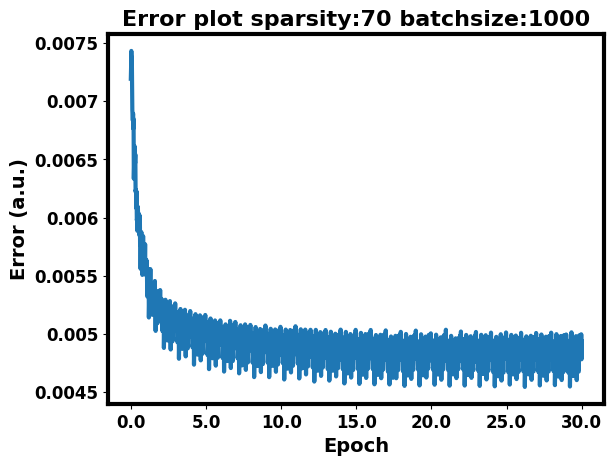

In [63]:
fig,ax=plt.subplots()
xaX=np.linspace(0,numIter,numIter*xTrain.shape[0]//batchSize)
ax.plot(xaX,TrainDict.err[:numIter*xTrain.shape[0]//batchSize],lw=3.0)
ax.set_xlabel('Epoch',fontsize=14,fontweight='bold')
ax.set_ylabel('Error (a.u.)',fontsize=14,fontweight='bold')
ax.set_xticklabels(np.round(ax.get_xticks()),fontsize=12,fontweight='bold')
ax.set_yticklabels(np.round(ax.get_yticks(),4),fontsize=12,fontweight='bold')
ax.spines[:].set_linewidth(3.0)
titleStr=f'Error plot sparsity:{spp} batchsize:{batchSize}'
ax.set_title(titleStr,fontsize=16,fontweight='bold')
plt.savefig(f'FMnist_Error_plot_sparsity_{spp}_batchsize_{batchSize}.svg',format='svg',dpi=300)

In [ ]:
def reconstructData(TrainDict,trainSetMean):
    reconData=(TrainDict.dict@TrainDict.proj+trainSetMean)
    reconData*=reconData>=0.0 # renormalizing between 0 and 255
    reconData=(reconData/np.max(reconData,axis=0))*255.0
    return reconData

In [ ]:
def showReconOrigComparison(reconData,trainData,ind):
    fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(14,7))
    ax[0].imshow(reconData[:,ind].reshape(28,28))
    ax[0].set_title('Reconstruction',fontsize=16,fontweight='bold')
    ax[1].imshow(trainData[ind,:,:])
    ax[1].set_title('Original',fontsize=16,fontweight='bold')

In [ ]:
reconDataTrain=reconstructData(TrainDict,trainSetMean)
ind=np.random.randint(xTrain.shape[0])
showReconOrigComparison(reconDataTrain,xTrain,ind)
#plt.savefig('Random_reconstructionFashionMNIST.svg',format='svg',dpi=300)